 Analyse walking trajectories starting with the human annotations
 see ./animate/walking_annotation_notes.md for the annotation scheme

In [35]:
import sys, os
join = lambda *x: os.path.abspath(os.path.join(*x))
import numpy as np
import json
import _fj
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import shutil

import twanalyse


In [36]:
# config
verbose = False


In [37]:
# paths
# notedir = os.path.normpath(os.path.dirname(__file__))
notedir = os.getcwd()
tagfile = join(notedir, "./animate/walking_meta.json")
with open(tagfile, 'r') as f:
    tagdata = json.load(f)

def tokey(idx): 
    # convert back to key from idx
    return '{:04d}'.format(int(idx))


In [38]:
lowaspect_idx, lowaspect_trs = _fj.slicehelper.load_trs('default_walking_list')
all_idx, ltrs = _fj.slicehelper.load_linearized_trs('all')


100%|██████████| 3113/3113 [00:01<00:00, 2752.63it/s]


In [39]:
# first compare tag data with low aspect set
print("found tags for {} tracks".format(len(tagdata.keys())))
print("number of tracks in low aspect set {}".format(len(lowaspect_idx)))
tagidx = np.array([int(k) for k in tagdata.keys()])
if len(tagdata.keys()) != len(lowaspect_idx):
    missing_up = lowaspect_idx[~np.in1d(lowaspect_idx, tagidx)]
    missing_down = tagidx[~np.in1d(tagidx, lowaspect_idx)]
    print("missing tags {}, missing trajectory".format(missing_up, missing_down))
else:
    print("continue...")


found tags for 371 tracks
number of tracks in low aspect set 371
continue...


In [40]:
# check the tags
import collections

tagcount = collections.Counter()
for tags in tagdata.values():
    tagcount.update(tags)
print(tagcount)

# a stacked bar graph showing the number of walking, crawling 
# and static tags and in addition the number of pure ["walking"] tags in particular
def popitem(item, lst):
    # pop item from list if it exists else return None
    if item in lst:
        return lst.pop(lst.index(item))
    else:
        return None
    

permitted = ["persistent", "persistent?"]
def get_pure(target, permitted=[]):
    pure_idx = []
    for idx, tags in tagdata.items():
        tags = copy(tags)
        c1 = popitem(target, tags)
        if c1:
            permit = True
            for tag in tags:
                if tag not in permitted:
                    permit = False
        if bool(c1) and permit:
            pure_idx.append(idx)
    return pure_idx
    
pure_walking_kidx = get_pure("walking", permitted)
pure_crawling_kidx = get_pure("crawling", permitted)
pure_static_kidx = get_pure("static", 
    ["horizontal", "horizontal?", "vertical", "vertical?"])
def _include_uncertain_get(word):
    return tagcount[word] + tagcount[word+'?']
barhdata = [
    [len(pure_walking_kidx), _include_uncertain_get("walking")],
    [len(pure_crawling_kidx), _include_uncertain_get("crawling")],
    [len(pure_static_kidx), _include_uncertain_get("static")]
]
barhdata
# TODO plot this as stacked bar



Counter({'walking': 207, 'crawling': 74, 'static': 40, 'transition': 34, 'horizontal': 20, 'short': 20, 'crawling?': 18, 'vertical': 16, 'transition?': 16, 'walking?': 14, 'persistent': 6, 'static_pole?': 5, 'static_pole': 4, 'walking, crawling, transition': 4, 'bidirectional?': 1, 'static?': 1, 'horizontal?': 1, 'persistent?': 1})


[[175, 221], [46, 92], [37, 41]]

In [41]:
# not all trajectories are mode equal, look are pure walking distributions
pure_walking_idx = np.array(list(map(int,  pure_walking_kidx)))
pure_walking_trs = [ltrs[idx] for idx in pure_walking_idx]


In [42]:
# I give the walking trajectories about 50/50 odds of having their surface 
# and off surface poles correctly identified
# create a little dataset to test this assessment
rg = np.random.RandomState(0)
smallset = sorted(rg.choice(pure_walking_idx, 20, replace=False))
# go ahead and shift these animations into a new folder
tdir = join(notedir, "./animate/smallset/")
if not os.path.exists(tdir):
    os.makedirs(tdir)
form = join(notedir, "./animate/walking/animate_{:04d}.mp4")
for idx in smallset:
    target = form.format(idx)
    if verbose:
        print("{} --> {}".format(target, tdir))
    shutil.copy2(target, tdir)
# create a template json file
smalldatapath = join(tdir, "smallset.json")
if not os.path.exists(smalldatapath):
    print("writing data template to {}".format(smalldatapath))
    template = collections.OrderedDict([(tokey(k), []) for k in sorted(smallset)])
    content = json.dumps(template, indent=1)
    with open(smalldatapath, "w") as f:
        f.write(content)
# load back the human annotations with or ["flipped"] empty []
with open(smalldatapath, 'r') as f:
    flipdata = json.load(f)
# count the flips
nflips = sum(map(int, ['flipped' in tags for tags in flipdata.values()]))
accuracy = 1. - float(nflips)/len(flipdata)
print('pole identification accuracy approx {:.1f}%'.format(100*accuracy))


pole identification accuracy approx 60.0%


 so lets improve this by comparing two things:
 (i) the distance traveled of the two poles
 (ii) the correlation of body vector with direction

In [43]:
# compute a better algorithm for identifying the head
norm = np.linalg.norm
def pole_travel(tr):
    # negative score implies poles should be flipped 
    adx = tr.get_step_dx()
    bdx = tr.get_step_dx(trail=True)
    atravel = np.sum(norm(adx, axis=1))
    btravel = np.sum(norm(bdx, axis=1))
    return atravel, btravel

def pole_travel_score(tr):
    atravel, btravel = pole_travel(tr)
    score = (btravel-atravel)/(btravel+atravel)
    return score

def body_corr(tr):
    # compute the correlation between body orientation and movement direction
    apole = tr.get_head()[:,:2]
    bpole = tr.get_trail()[:,:2]
    # compute body direction
    body = apole - bpole
    normalize = norm(body,axis=1)[:,np.newaxis]
    with np.errstate(divide='ignore', invalid='ignore') as errstate:
        body = body/normalize 
    body[np.isnan(body)] = 0. # set nan to zero
    # compute movement direction
    center = (apole + bpole)/2
    center_dx = center[1:] - center[:-1]
    normv = norm(center_dx,axis=1)[:,np.newaxis]
    movement = center_dx/normv
    # dot product
    product = np.sum(movement*body[1:],axis=1)
    corr = np.mean(product)
    return corr

def flip_score(tr):
    return body_corr(tr) + pole_travel_score(tr)

def print_scores():
    agree = []
    disagree = []
    for idx in smallset:
        tr = ltrs[idx]
        score = flip_score(tr)
        # print(idx, flipdata[tokey(idx)], 'score', score)
        human_flip = 'flipped' in flipdata[tokey(idx)]
        machine_flip = score < 0
        if human_flip == machine_flip:
            agree.append(idx)
        else:
            disagree.append(idx)
    accuracy = float(len(agree))/len(smallset)
    print("human + machine agreement {:.1f}%".format(100*accuracy))
print_scores()


human + machine agreement 90.0%


In [44]:
# lets apply the pole flipping algorithm
# NOTE: This operation changes the data!
flip_scores = []
nflips = 0
for tr in pure_walking_trs:
    score = flip_score(tr)
    flip_scores.append(score)
    if score < 0:
        tr.flip_poles()
        nflips += 1
print("flip poles in pure walking dataset where appropriate")
print("{} flips".format(nflips))
    

flip poles in pure walking dataset where appropriate
71 flips


71/175 flips


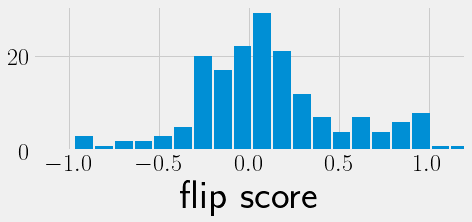

In [45]:
# compute leading and trailing pole velocities

nbins = 20
fig = plt.figure(figsize=(6,2))
ax = fig.add_axes([1,1,1,1])
ax.hist(flip_scores, bins=20, rwidth=0.9)
ax.set_xlim((-1.2,1.2))
ax.set_xlabel("flip score")
print("{}/{} flips".format(nflips,len(pure_walking_idx)))


In [46]:
duration = [tr.get_duration() for tr in pure_walking_trs]
nsteps = [len(tr.step_idx)-1 for tr in pure_walking_trs]
head_speed = [np.mean(tr.get_step_speed()) for tr in pure_walking_trs]
trail_speed = [np.mean(tr.get_step_speed(trail=True)) for tr in pure_walking_trs]
print("leading pole mean speed ", np.mean(head_speed))
print("trailing pole mean speed ", np.mean(trail_speed))
# persistence calculation
q_estimate = []
a_estimate = []
step_aspect = []
aspect_mean = []
aspect_var = []
for tr in pure_walking_trs:
    sd = twanalyse.mle_persistence([tr])
    q = sd['q']['estimate']
    a = sd['a']['estimate']
    q_estimate.append(q)
    a_estimate.append(a)
    # compute variance of aspect ratio
    aspect = tr['length']/tr['width'] 
    aspect_mean.append(np.mean(aspect))
    aspect_var.append(np.var(aspect))
    step_aspect.append(tr['length'][tr.step_idx]/tr['width'][tr.step_idx])



leading pole mean speed  0.5531905188673579
trailing pole mean speed  0.48940481992237195


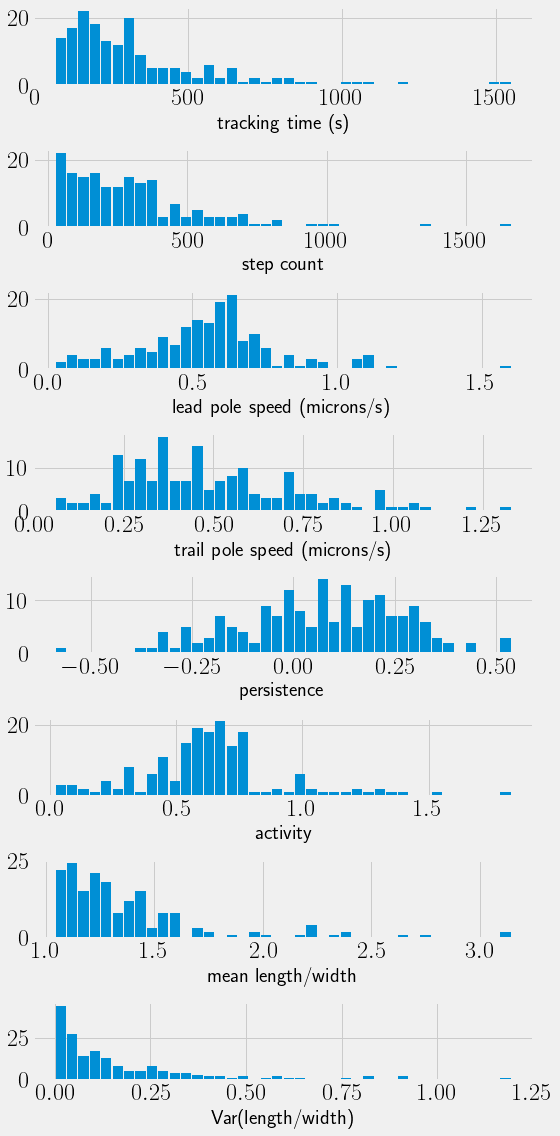

In [47]:
# plotting distributions
# distance travelled, persistence, aspect ratio fluctuations ...
histstyle = {'bins':40, 'rwidth':0.9}
xproperty = [
    "tracking time (s)", "step count", "lead pole speed (microns/s)", 
    "trail pole speed (microns/s)", "persistence", "activity",
    "mean length/width", "Var(length/width)"
    ]
data = [duration, nsteps, head_speed, trail_speed, q_estimate, a_estimate, 
    aspect_mean, aspect_var]
fig, axes = plt.subplots(len(xproperty),1,figsize=(8,len(xproperty)*2))
for i, ax in enumerate(axes):
    ax.hist(data[i], **histstyle)
    ax.set_xlabel(xproperty[i], fontsize='x-large')

plt.tight_layout()


Text(0.5, 0, 'pearson correlation')

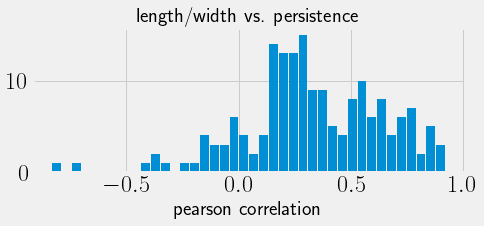

In [48]:
# is aspect ratio correlated with persistence?
from glob import glob
precomputed_dir = join(notedir, './persistance/data/stepfj')

def load_precomputed(datadir, target_idx):
    a_form = 'avgPost_*'
    b_form = 'postMean_*'
    a_lst = sorted(glob(os.path.join(datadir, a_form)))
    b_lst = sorted(glob(os.path.join(datadir, b_form)))
    avgPost = [np.load(a_lst[idx]) for idx in target_idx]
    postMean = [np.load(b_lst[idx]) for idx in target_idx]
    return avgPost, postMean
avgPost, postMean = load_precomputed(precomputed_dir, pure_walking_idx)
step_q = [p[0] for p in postMean]
step_a = [p[1] for p in postMean]
timebase = [tr['time'][np.array(tr.step_idx[1:-1])] for tr in pure_walking_trs]


pa_corrcoef = []
for i, tr in enumerate(pure_walking_trs):
    aspect = step_aspect[i][1:-1]
    corr = np.corrcoef(step_q[i], aspect)
    pa_corrcoef.append(corr[0,1])

fig = plt.figure(figsize=(6,2))
ax = fig.add_axes([1,1,1,1])
ax.hist(pa_corrcoef, **histstyle)
ax.set_title("length/width vs. persistence")
ax.set_xlabel("pearson correlation", fontsize='x-large')


<AxesSubplot:title={'center':'crawling candidate example track'}, xlabel='time (s)'>

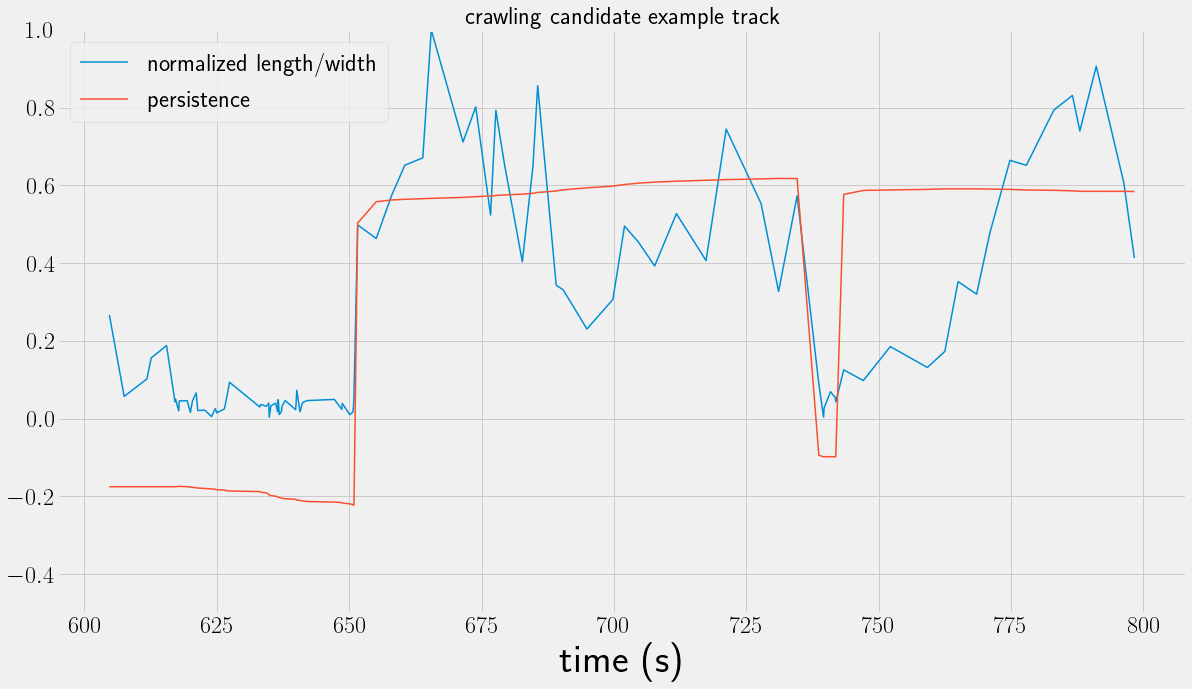

In [49]:
# pick out an example track
sortcoef = sorted(enumerate(pa_corrcoef), key=lambda x: x[1])
idx, coef = sortcoef[int(0.95* len(sortcoef))]
ax = plt.gca()
aspect_score = step_aspect[idx][1:-1] - 1.0
ax.plot(timebase[idx], aspect_score/np.max(aspect_score), label="normalized length/width")
ax.plot(timebase[idx], step_q[idx], label="persistence")
ax.legend(fontsize='xx-large')
ax.set_xlabel("time (s)")
ax.set_ylim(-0.5,1.0)
ax.set_title("crawling candidate example track", fontsize="xx-large")
ax


In [50]:
if verbose:
    candidate_idx = 2924
    cand_q, cand_a = np.load(join(precomputed_dir, "postMean_2924.npy"))
    tr = ltrs[candidate_idx]
    aspect = tr['length'][tr.step_idx]/tr['width'][tr.step_idx]
    ax =plt.gca()
    ax.plot(cand_q)
    aspect_score = aspect[1:-1] -1.0
    ax.plot(aspect_score/np.max(aspect_score))
    ax.set_ylim(0,1.0)
    coef = np.corrcoef(cand_q, aspect[1:-1])
    print('candidate correlation', coef[0,1])


In [51]:
# recompute persistence data for flipped pole trajectories
sys.path.append(join(notedir, './tools'))
import bayesloop
import matdef
control = {'pMin': 1e-18}
save_dir = join(notedir, './persistance/data/stepfj')

# we could use multiple cores
naming_form = os.path.join(save_dir, '{{}}_{:04d}.npy')
basis_form = os.path.join(save_dir, 'timebase_{:04d}.npy')
def persistance_analyse(idx):
    track = ltrs[idx]
    naming_form_partial = naming_form.format(idx)
    step_idx = np.array(track.step_idx)
    analyser = bayesloop.BayesLoop()
    for k, v in control.items():
        setattr(analyser, k, v)
    step_xy = np.column_stack([track['x'][step_idx], track['y'][step_idx]])
    step_time = matdef.TIMESTEP * (step_idx[1:] - step_idx[:-1])
    time_basis = track['time'][step_idx] - track['time'][0]
    np.save(basis_form.format(idx), time_basis)
    step_u = (step_xy[1:] - step_xy[:-1]) / step_time[:, np.newaxis]
    analyser.data = step_u
    analyser.startAnalysis()
    analyser.save(naming_form_partial)
    del analyser # should go out of scope anyway

if verbose:
    for i, idx in enumerate(pure_walking_idx):
        persistance_analyse(idx)


